In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
DATA_DIR = './RAFDB'
EPOCHS = 50
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
PATIENCE = 10

In [3]:
#use gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [4]:
#data preprocess
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),                     
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))     
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406),
                         std=(0.229, 0.224, 0.225))
])


In [5]:
#load data
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
num_classes = len(train_dataset.classes)
print("Classes:", train_dataset.classes)

Classes: ['1', '2', '3', '4', '5', '6', '7']


In [7]:
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout 
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)


D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\Anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
#loss function and optimizer
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [9]:
# train function
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# validate function
def validate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [10]:
best_val_acc = 0.0
patience_counter = 0

train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation improved. Model saved.")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")
        if patience_counter >= PATIENCE:
            print("Early stopping triggered.")
            break


Epoch 1/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.58it/s]


Train Loss: 1.3260, Accuracy: 59.47%
Val Loss: 1.0208, Accuracy: 74.87%
Validation improved. Model saved.

Epoch 2/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.28it/s]


Train Loss: 0.9941, Accuracy: 76.09%
Val Loss: 0.9098, Accuracy: 78.55%
Validation improved. Model saved.

Epoch 3/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.99it/s]


Train Loss: 0.8819, Accuracy: 81.13%
Val Loss: 0.8662, Accuracy: 81.23%
Validation improved. Model saved.

Epoch 4/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.11it/s]


Train Loss: 0.8135, Accuracy: 85.01%
Val Loss: 0.8650, Accuracy: 82.07%
Validation improved. Model saved.

Epoch 5/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.82it/s]


Train Loss: 0.7501, Accuracy: 87.52%
Val Loss: 0.8296, Accuracy: 82.72%
Validation improved. Model saved.

Epoch 6/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.61it/s]


Train Loss: 0.6972, Accuracy: 90.85%
Val Loss: 0.8346, Accuracy: 83.28%
Validation improved. Model saved.

Epoch 7/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.32it/s]


Train Loss: 0.6564, Accuracy: 92.61%
Val Loss: 0.8298, Accuracy: 83.44%
Validation improved. Model saved.

Epoch 8/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.42it/s]


Train Loss: 0.6264, Accuracy: 94.30%
Val Loss: 0.8340, Accuracy: 83.93%
Validation improved. Model saved.

Epoch 9/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.66it/s]


Train Loss: 0.6009, Accuracy: 95.56%
Val Loss: 0.8296, Accuracy: 83.87%
No improvement. Patience: 1/10

Epoch 10/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.25it/s]


Train Loss: 0.5752, Accuracy: 96.72%
Val Loss: 0.8108, Accuracy: 85.23%
Validation improved. Model saved.

Epoch 11/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.43it/s]


Train Loss: 0.5623, Accuracy: 97.33%
Val Loss: 0.8026, Accuracy: 84.84%
No improvement. Patience: 1/10

Epoch 12/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.47it/s]


Train Loss: 0.5398, Accuracy: 98.31%
Val Loss: 0.8099, Accuracy: 84.78%
No improvement. Patience: 2/10

Epoch 13/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.38it/s]


Train Loss: 0.5293, Accuracy: 98.66%
Val Loss: 0.7985, Accuracy: 85.33%
Validation improved. Model saved.

Epoch 14/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.36it/s]


Train Loss: 0.5213, Accuracy: 98.83%
Val Loss: 0.8044, Accuracy: 85.37%
Validation improved. Model saved.

Epoch 15/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.14it/s]


Train Loss: 0.5130, Accuracy: 99.14%
Val Loss: 0.8163, Accuracy: 84.45%
No improvement. Patience: 1/10

Epoch 16/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.26it/s]


Train Loss: 0.5064, Accuracy: 99.38%
Val Loss: 0.8023, Accuracy: 84.55%
No improvement. Patience: 2/10

Epoch 17/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.45it/s]


Train Loss: 0.5033, Accuracy: 99.41%
Val Loss: 0.8227, Accuracy: 84.22%
No improvement. Patience: 3/10

Epoch 18/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.17it/s]


Train Loss: 0.5011, Accuracy: 99.41%
Val Loss: 0.7865, Accuracy: 85.01%
No improvement. Patience: 4/10

Epoch 19/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.15it/s]


Train Loss: 0.4966, Accuracy: 99.42%
Val Loss: 0.7924, Accuracy: 85.17%
No improvement. Patience: 5/10

Epoch 20/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.71it/s]


Train Loss: 0.4935, Accuracy: 99.49%
Val Loss: 0.7976, Accuracy: 85.30%
No improvement. Patience: 6/10

Epoch 21/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 10.81it/s]


Train Loss: 0.4899, Accuracy: 99.58%
Val Loss: 0.8089, Accuracy: 84.65%
No improvement. Patience: 7/10

Epoch 22/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.46it/s]


Train Loss: 0.4868, Accuracy: 99.75%
Val Loss: 0.7884, Accuracy: 85.23%
No improvement. Patience: 8/10

Epoch 23/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.65it/s]


Train Loss: 0.4844, Accuracy: 99.67%
Val Loss: 0.7861, Accuracy: 84.68%
No improvement. Patience: 9/10

Epoch 24/50


Validation: 100%|██████████████████████████████████████████████████████████████████████| 48/48 [00:04<00:00, 11.38it/s]

Train Loss: 0.4845, Accuracy: 99.60%
Val Loss: 0.7947, Accuracy: 85.07%
No improvement. Patience: 10/10
Early stopping triggered.


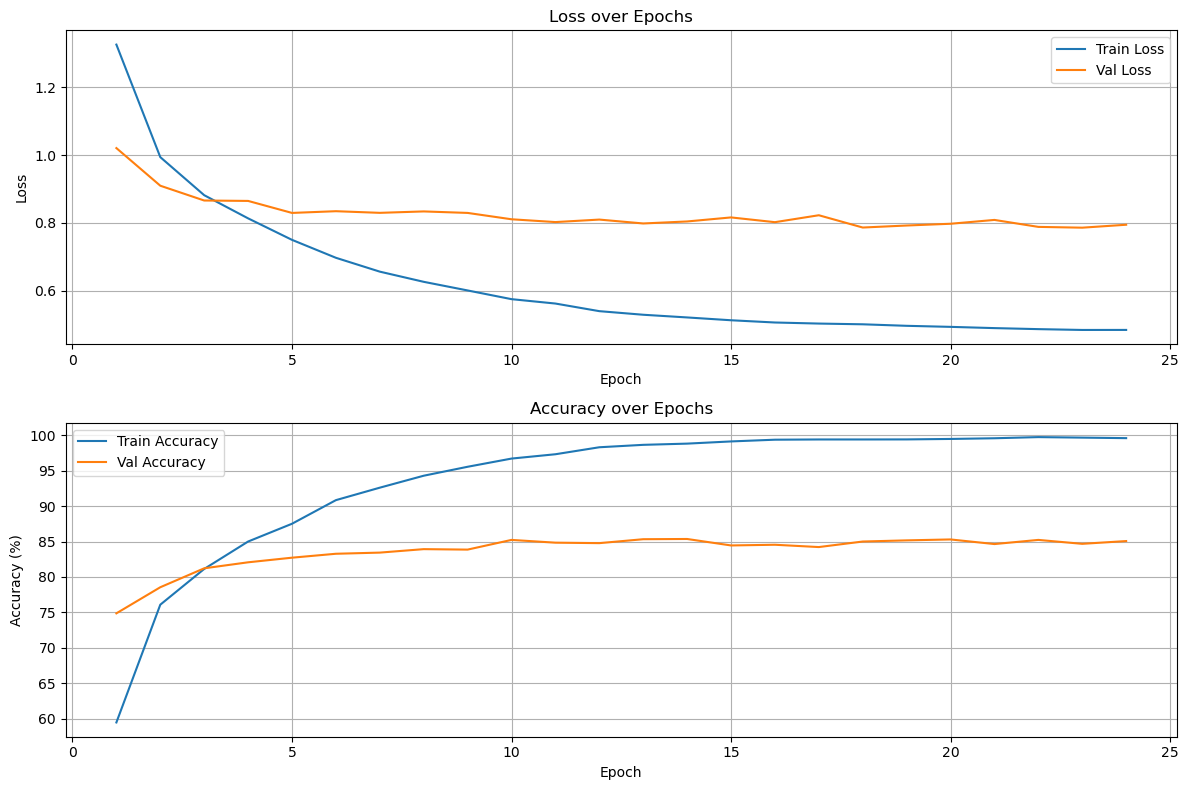

In [11]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, val_accs, label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_9404\406191497.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Classification Report:
               precision    recall  f1-score   support

           1       0.91      0.82      0.86       329
           2       0.75      0.59      0.66        74
           3       0.74      0.43      0.55       160
           4       0.94      0.94      0.94      1185
           5       0.83      0.81      0.82       478
           6       0.77      0.78      0.78       162
           7       0.77      0.89      0.82       680

    accuracy                           0.85      3068
   macro avg       0.81      0.75      0.78      3068
weighted avg       0.85      0.85      0.85      3068



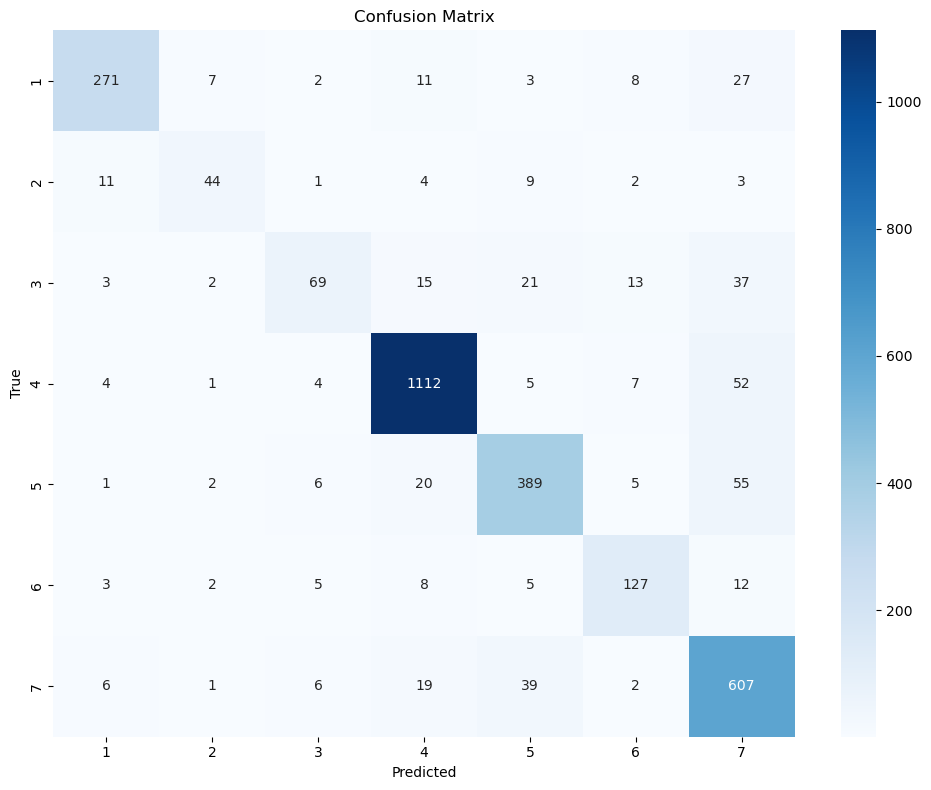

In [12]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# loadmodel
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# confusion matrix and report
cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=train_dataset.classes)

# report
print("Classification Report:\n", report)

# confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


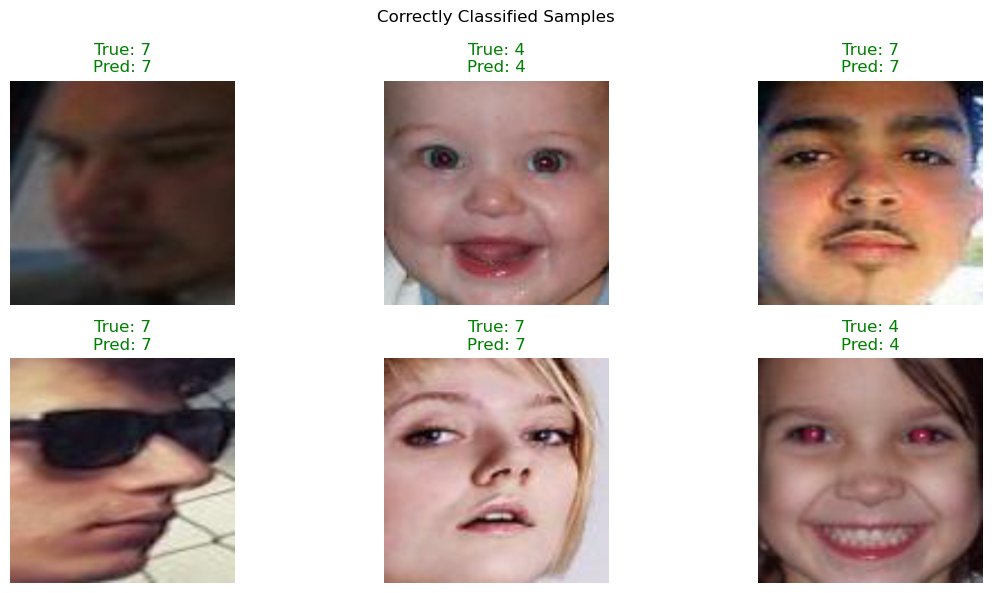

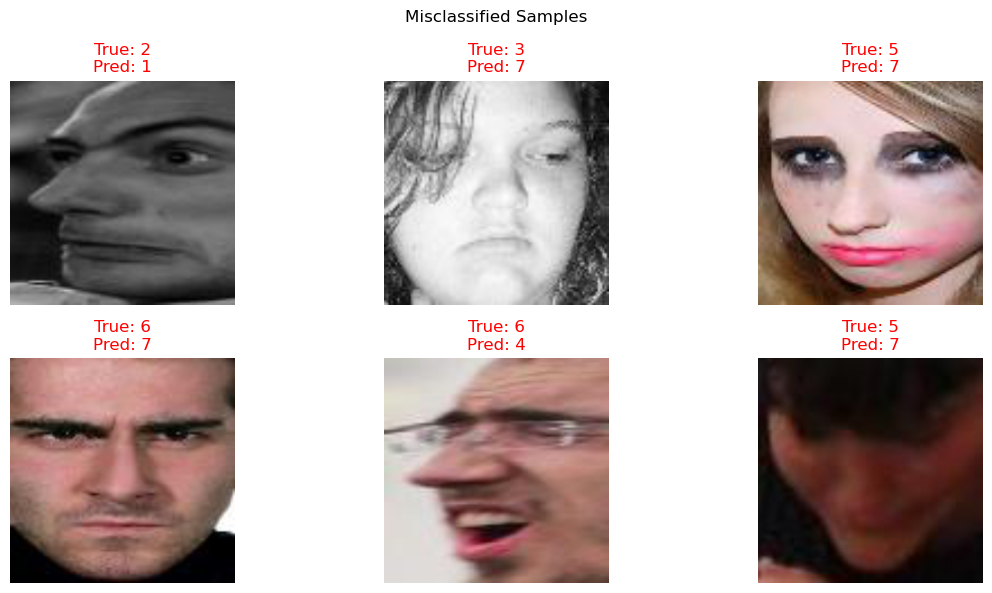

In [13]:
import random
import matplotlib.pyplot as plt


images_list = []
preds_list = []
labels_list = []


model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)

        images_list.extend(images.cpu())
        preds_list.extend(preds.cpu())
        labels_list.extend(labels.cpu())


correct_indices = [i for i in range(len(labels_list)) if preds_list[i] == labels_list[i]]
incorrect_indices = [i for i in range(len(labels_list)) if preds_list[i] != labels_list[i]]


def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

def show_samples(indices, title):
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(random.sample(indices, min(6, len(indices)))):
        image = unnormalize(images_list[idx])  
        true_label = train_dataset.classes[labels_list[idx]]
        pred_label = train_dataset.classes[preds_list[idx]]

        if image.shape[0] == 3:
            image = image.permute(1, 2, 0)  
        else:
            image = image.squeeze(0)

        image = torch.clamp(image, 0, 1) 

        plt.subplot(2, 3, i + 1)
        plt.imshow(image.numpy())
        plt.title(f"True: {true_label}\nPred: {pred_label}",
                  color='green' if true_label == pred_label else 'red')
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()



show_samples(correct_indices, "Correctly Classified Samples")


show_samples(incorrect_indices, "Misclassified Samples")
